Connect to google drive

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


Read input video (Change **FILEPATH** to the video you are going to use)

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import csv

Input your own json folder path and your label csv file path here to './drive/My Drive/636/test/'

In [0]:
FOLDER = './drive/My Drive/636/test/'
LABEL_PATH = './drive/My Drive/636/test/label.csv'

In [0]:
N_FACE = 70
N_POSE = 8
N_FEATURES = (N_FACE + N_POSE) * 2
MODEL_FOLDER = './drive/My Drive/636/model/'

COL_NAMES = ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]

In [0]:
# collect the json output of openpose and combine them into csv
def json_to_csv(folderpath, csv_path):
  idx = 0
  write_file = open(csv_path, 'w')
  csv_writer = csv.writer(write_file)
  csv_writer.writerow(COL_NAMES) 
  for name in sorted(os.listdir(folderpath)): 
    if name[-4:] == 'json':
      filepath = os.path.join(folderpath, name)
      if os.path.isfile(filepath):
        with open(filepath, 'r') as f:
          data = json.load(f)['people']
          if len(data) > 0:
            row_face = [float(data[0]['face_keypoints_2d'][j]) for j in idx_f]
            row_pose = [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
            row = row_face + row_pose
            row = np.array(row)
            csv_writer.writerow(row)
      idx += 1

def get_csv(name):
  folderpath = FOLDER
  csv_path = FOLDER + name
  json_to_csv(folderpath, csv_path)

In [0]:
get_csv('test.csv')

In [0]:
X = pd.read_csv(FOLDER + 'test.csv')

In [0]:
y = pd.read_csv(LABEL_PATH).to_numpy()

Reshape Data into Segments and Prepare for Keras

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, fps, TIME_STEP):
  slices = []
  ts = []
  for i in range(df.shape[0]):
    ts.append(i/fps)
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  ts_arr = np.asarray(ts, dtype= np.float32)
  return slices_arr, ts_arr

Load model and weight

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten
from keras.callbacks import History, EarlyStopping
from keras.models import load_model

TensorFlow is already loaded. Please restart the runtime to change versions.


Draw figure

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

def drawplt(time, pred):
  plt.figure(figsize=(10,8))
  plt.plot(time, pred, 'b', label='prediction', markersize=3, color='red')
  plt.title('Prediction over time')
  plt.legend()
  plt.show()

Generate json

In [0]:
def to_json(filepath):
  np_pred = np.array((ts_arr, y_pred.flatten())).T
  pred_list = np_pred.tolist()
  pred_dict = {"cry":pred_list}
  pred_json = json.dumps(pred_dict)
  with open(filepath, 'w') as json_file:
    json_file.write(pred_json)

Automation

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
# get input


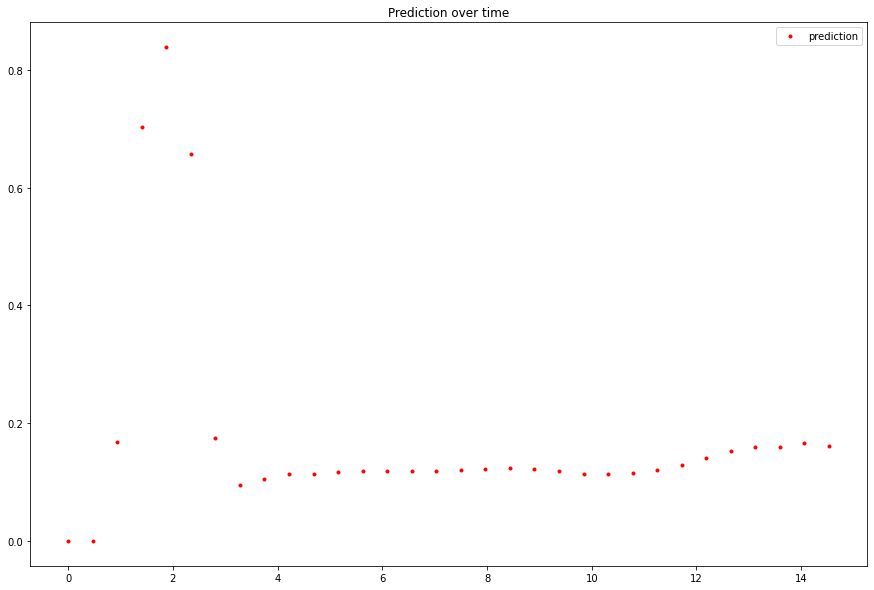

In [0]:
# load model
model = load_model(MODEL_FOLDER + 'bi_rmsprop.h5')
# get input and timestep
t = 15.0
frames = X.shape[0]
fps = frames / t
X_arr, ts_arr = get_slices(X, fps, 10)
# get prediction
y_pred = model.predict(X_arr)
# draw plot
drawplt(ts_arr, y_pred)
# output json file
to_json(FOLDER + 'test.json')

In [0]:
y_pred_n = []
for i in y_pred:
  if i < 0.5:
    y_pred_n.append(0)
  else:
    y_pred_n.append(1)
accuracy_score(y, y_pred_n)

0.90625